In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 256) 
        self.fc2 = nn.Linear(256, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [25]:
torch.manual_seed(7)

In [26]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=64, shuffle=True)

C:\Users\ianey\AppData\Local\Temp\ipykernel_11868\2182951934.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
C:\Users\ianey\AppData\Local\Temp\ipykernel_11868\2182951934.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [27]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=64, shuffle=True)

C:\Users\ianey\AppData\Local\Temp\ipykernel_11868\2331197148.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
C:\Users\ianey\AppData\Local\Temp\ipykernel_11868\2331197148.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [28]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    diff = (torch.sum(torch.abs(inl.weight.data - ninc)).item(), torch.sum(torch.abs(oul.weight.data-noul)).item())

    inl.weight.data = ninc
    oul.weight.data = noul

    return diff


In [29]:
model = model.to('cuda')
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

num_epochs = 20  
for epoch in range(num_epochs):
    for b in tqdm(trainloader):
        xt, y = b[0].to('cuda'), b[1].to('cuda')
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
    
    for i in range(len(lay)):
        if i > 0 and i <= len(lay)-1:
            di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])
            while(di[0]+di[1] > .001):
                di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0].to('cuda'), i[1].to('cuda')
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')


Linear
Linear
Linear


100%|██████████| 938/938 [00:02<00:00, 435.91it/s]


Epoch 0/20, Loss: 0.017257506027817726
test dataset accuracy: 93.9%


100%|██████████| 938/938 [00:02<00:00, 445.49it/s]


Epoch 1/20, Loss: 0.020788012072443962
test dataset accuracy: 92.9%


100%|██████████| 938/938 [00:02<00:00, 437.11it/s]


Epoch 2/20, Loss: 0.006060359533876181
test dataset accuracy: 92.33%


100%|██████████| 938/938 [00:02<00:00, 439.87it/s]


Epoch 3/20, Loss: 0.014792772941291332
test dataset accuracy: 93.45%


100%|██████████| 938/938 [00:01<00:00, 470.79it/s]


Epoch 4/20, Loss: 0.017109131440520287
test dataset accuracy: 92.57%


100%|██████████| 938/938 [00:02<00:00, 460.15it/s]


Epoch 5/20, Loss: 0.00751724187284708
test dataset accuracy: 92.06%


100%|██████████| 938/938 [00:02<00:00, 454.59it/s]


Epoch 6/20, Loss: 0.014271825551986694
test dataset accuracy: 89.99%


100%|██████████| 938/938 [00:02<00:00, 456.52it/s]


Epoch 7/20, Loss: 0.011983583681285381
test dataset accuracy: 93.7%


100%|██████████| 938/938 [00:02<00:00, 443.34it/s]


Epoch 8/20, Loss: 0.02160746417939663
test dataset accuracy: 93.0%


100%|██████████| 938/938 [00:01<00:00, 469.73it/s]


Epoch 9/20, Loss: 0.0065590739250183105
test dataset accuracy: 92.0%


100%|██████████| 938/938 [00:01<00:00, 487.74it/s]


Epoch 10/20, Loss: 0.010033519007265568
test dataset accuracy: 92.53%


100%|██████████| 938/938 [00:02<00:00, 459.19it/s]


Epoch 11/20, Loss: 0.011018192395567894
test dataset accuracy: 93.39%


100%|██████████| 938/938 [00:02<00:00, 457.71it/s]


Epoch 12/20, Loss: 0.011197749525308609
test dataset accuracy: 93.8%


100%|██████████| 938/938 [00:01<00:00, 481.73it/s]


Epoch 13/20, Loss: 0.009397327899932861
test dataset accuracy: 93.49%


100%|██████████| 938/938 [00:01<00:00, 485.18it/s]


Epoch 14/20, Loss: 0.008995267562568188
test dataset accuracy: 94.37%


100%|██████████| 938/938 [00:01<00:00, 476.55it/s]


Epoch 15/20, Loss: 0.012673372402787209
test dataset accuracy: 93.32%


100%|██████████| 938/938 [00:02<00:00, 453.22it/s]


Epoch 16/20, Loss: 0.008565152995288372
test dataset accuracy: 94.27%


100%|██████████| 938/938 [00:02<00:00, 467.27it/s]


Epoch 17/20, Loss: 0.008186958730220795
test dataset accuracy: 93.62%


100%|██████████| 938/938 [00:01<00:00, 488.63it/s]


Epoch 18/20, Loss: 0.007172692101448774
test dataset accuracy: 93.63%


100%|██████████| 938/938 [00:02<00:00, 466.96it/s]


Epoch 19/20, Loss: 0.009727354161441326
test dataset accuracy: 93.87%


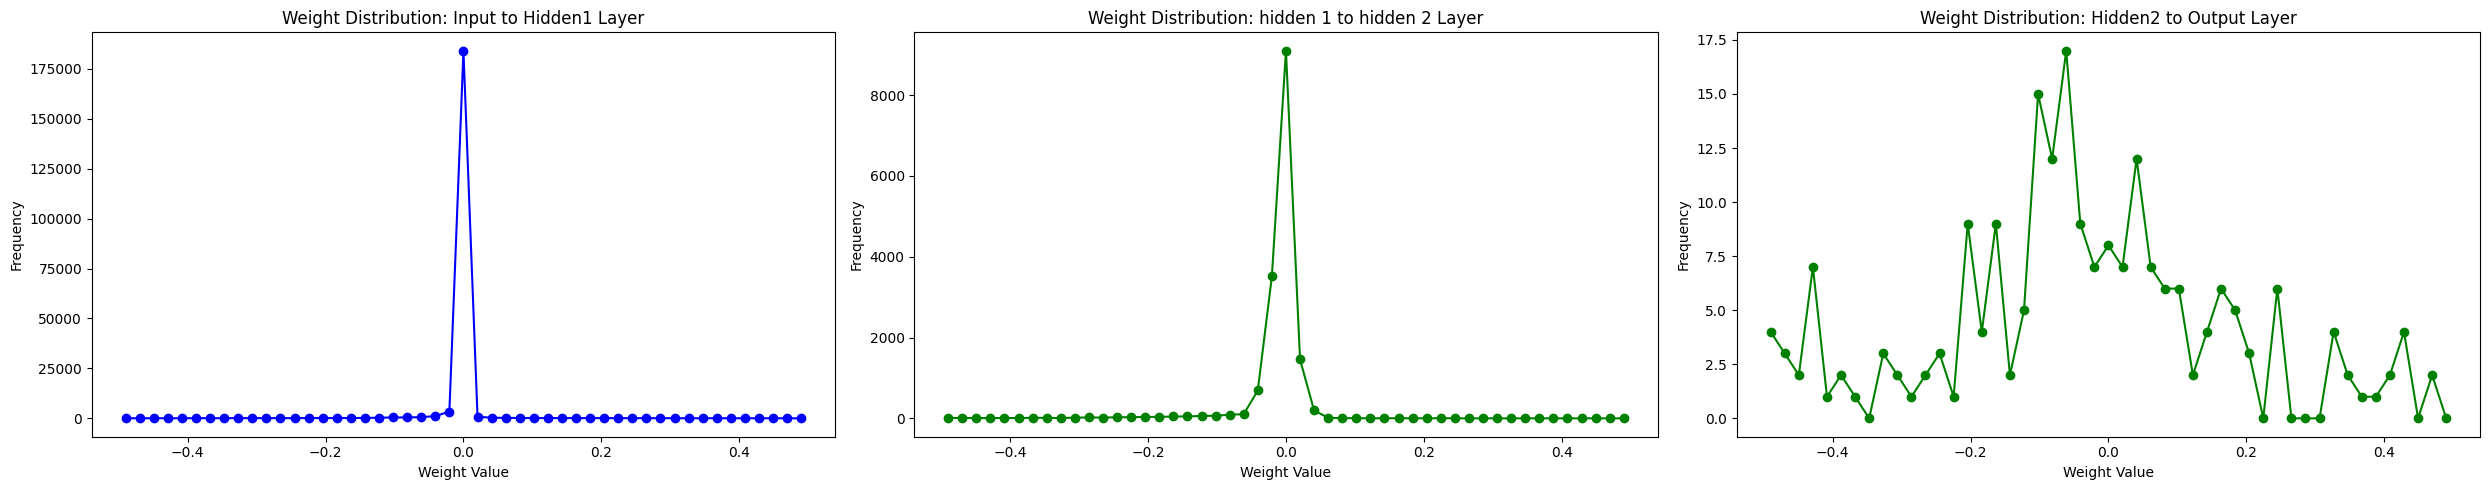

In [30]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [31]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 16921
Number of non-zero weights greater than 0.01 in layer 1: 7382
Number of non-zero weights greater than 0.01 in layer 3: 632


In [32]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.95483223518753, 0.9548248174947612, 0.9549668212679144, 0.9548347925078787, 0.9552853015420532, 0.9552056641101437, 0.954984358263673, 0.9543538596933575, 0.9554029722748424, 0.9548797891699855, 0.9553704406929331, 0.9552888016198734, 0.9549450362171397, 0.9547482707369259, 0.9548918168034687, 0.9524712608695958, 0.9552597972057617, 0.9544096189126534, 0.9542763754908921, 0.9549438499297223, 0.954979328322907, 0.9545369246175123, 0.9556241101488153, 0.9552254222182348, 0.9547353751422043, 0.9547934677160386, 0.9549013458125379, 0.9540029531453769, 0.9554431894179698, 0.9546162347964724, 0.9550736547760282, 0.9551930895043118, 0.9547551244463169, 0.9546706234014399, 0.9543829662475185, 0.9548138556821225, 0.9548658629892366, 0.9552825838672588, 0.955276189072016, 0.9544813413523663, 0.9550818860222914, 0.9540512683908324, 0.9551892989205004, 0.9550257240933877, 0.9552978976681219, 0.9548059906072431, 0.955075988000239, 0.9553680057221456, 0.9551018612034785, 0.9549115135495849, 0.954